In [1]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph

# Load Envs


In [2]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
# os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Set Up Langsmith

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

# Reducers

https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers

Reducers are key to understanding how updates from nodes are applied to the State. Each key in the State has its own independent reducer function. If no reducer function is explicitly specified then it is assumed that all updates to that key should override it.

In [5]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

# Build Graph

To use

```
class State(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]
```

check this [notebook](https://colab.research.google.com/drive/1YpPoyipJla92a-d6VHPg2AKUC4HBqZZ9?authuser=5#scrollTo=i7Wxnix0L2HT)

In [147]:
# Define State
class State(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]


## LLM

In [148]:
from langchain_groq import ChatGroq
llm = ChatGroq(model = 'llama-3.1-8b-instant') # This doesnot work well for pydantic type of intent classifier

In [149]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI() # This works for all

## Tools

#### RAG tool

In [150]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

In [151]:
# Load document
loader = PyPDFLoader("/content/FoodAdvisor.pdf")
pages = loader.load()

# Split Texts
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)


docs = text_splitter.split_documents(pages)

# Embedding Model
embeddings_model = OpenAIEmbeddings()

persist_directory="./chroma_db"

if os.path.isdir(persist_directory):
  # Load from disk
  db = Chroma(persist_directory=persist_directory, embedding_function=embeddings_model)
else:
  # Store on disk
  db = Chroma.from_documents(docs, embeddings_model, persist_directory=persist_directory)


# Retreiver
retriever = db.as_retriever()

In [152]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

In [153]:
def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

In [154]:
rag_prompt_template = """
  Answer the question based only on the following context:
  {context}

  Question: {question}

  Note: Never state anywhere in your conversation that the answers are from the context.
"""

In [155]:
def rag_function(state: State):
  print("---------- RAG Tool ----------")

  messages = state["messages"]
  question = messages[0] # {"messages" : [question, Intent Classifier, Response]}
  # print(question)


  prompt = ChatPromptTemplate.from_template(rag_prompt_template)

  rag_chain = (
    {"context" : retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
  )

  result = rag_chain.invoke(question)

  return {"messages" : [result]}


#### LLM Tool

In [156]:
def llm_function(state: State):
  print("---------- LLM Tool ----------")

  user_query = state["messages"][0]

  prompt = "Briefly answer the question in one or two line about user query. user_query: {}".format(user_query)

  llm_response = llm.invoke(prompt)
  result = llm_response.content

  return {"messages" : [result]}

#### Search Tool

In [157]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [158]:
def search_function(state: State):
  print("---------- Search Tool ----------")

  user_query = state["messages"][0]

  result = search.invoke(user_query)

  return {"messages" : [result]}



#### Wikipedia Search

In [159]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [160]:
def wikipedia_function(state: State):
  print("---------- Wikipedia Tool ----------")

  user_query = state["messages"][0]

  result = wikipedia.run(user_query)

  return {"messages" : [result]}

## Routers

#### Intent Classifier

[Pydantic Parser](https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/pydantic/)

In [161]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate

In [162]:
class TopicSelectionParser(BaseModel):
  Topic: str = Field(description="The Selected Topic")
  Reasoning: str = Field(description="Reasoning behind the selection")

In [163]:
# Set up a parser + inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object = TopicSelectionParser)

In [164]:
# Intent Classifier for Route
intentclassifier_prompt_template="""
  Your task is to classify the given user query into one of the following categories: [Restaurant, Wikipedia, Search, Not Restaurant].

  Only respond with the category name and nothing else.

  User query: {query}

  {format_instructions}
"""

In [165]:
def intent_classifier(state: State):
  print("----- Intent Classifier ------")

  prompt = PromptTemplate(
    template = intentclassifier_prompt_template,
    input_variables = ["query"],
    partial_variables = {"format_instructions": parser.get_format_instructions()},
)


  chain =  prompt | model | parser # use openai

  query = state["messages"][0] # {"messages" : [question, Intent Classifier, Response]}


  response = chain.invoke({"query":query,"format_instructions" : parser.get_format_instructions() })
  # print(response)

  return {"messages" : [response.Topic]}

### Router

In [166]:
def router(state:State):
  print("---------- Router ----------")

  intent_detected = state["messages"][-1]

  if intent_detected == "Restaurant":
    return "Call Rag Tool"
  elif intent_detected == "Wikipedia":
    return "Call Wikipedia Tool"
  elif intent_detected == "Search":
    return "Call Search Tool"
  else:
    return "Call LLM Tool"

The detected intent will be one from the following

```
[Restaurant, Wikipedia, Search, Not Restaurant]

[Restaurant -> Call Rag Tool]
[Wikipedia -> Call Wikipedia Tool]
[Search -> Call Search Tool]
[Not Restaurant -> Call LLM Tool]
```

Mapping Works Like:



```
# This is formatted as code

{
  "Call Rag Tool" : RAG Node,
  "Call Wikipedia Tool" : Wikipedia Node,
  "Call Search Tool" : Search Node,
  "Call LLM Tool" : LLM Node

}
```



# Build Graph

In [167]:
from langgraph.graph import START, END, StateGraph

In [168]:
# 1. Create Instance of the Graph
workflow = StateGraph(State)


# 2. Create Nodes
workflow.add_node("Classifier", intent_classifier)
workflow.add_node("RAG Node", rag_function)
workflow.add_node("Wikipedia Node", wikipedia_function)
workflow.add_node("Search Node", search_function)
workflow.add_node("LLM Node", llm_function)

# 3. Create Conditional Edges
workflow.add_conditional_edges(
    "Classifier",   # Intent Classifier
    router, # The routing function
    {
        "Call Rag Tool" : "RAG Node",
        "Call Wikipedia Tool" : "Wikipedia Node",
        "Call Search Tool" : "Search Node",
        "Call LLM Tool" : "LLM Node"
    }
)

## Create Entry Point
workflow.add_edge(START, "Classifier")

## Create Exit Point
workflow.add_edge("RAG Node", END)
workflow.add_edge("Wikipedia Node", END)
workflow.add_edge("Search Node", END)
workflow.add_edge("LLM Node", END)


# 4. Compile the Graph
my_graph = workflow.compile()

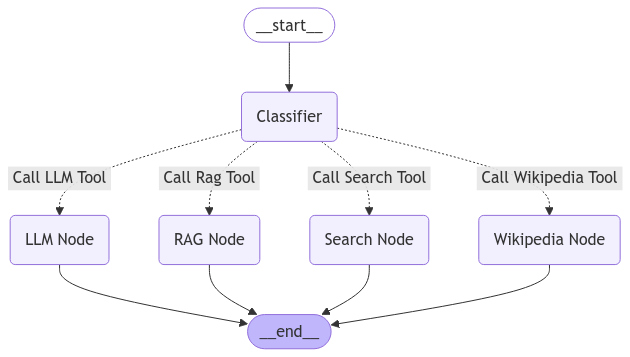

In [169]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

### Run the graph

In [170]:
user_input  = {"messages": ["Name few Restaurants in Malleswaram serving Vegetarian food"]}

In [171]:
result = my_graph.invoke(user_input)

----- Intent Classifier ------
---------- Router ----------
---------- RAG Tool ----------


In [172]:
result

{'messages': ['Name few Restaurants in Malleswaram serving Vegetarian food',
  'Restaurant',
  'Here are a few restaurants in Malleswaram serving Vegetarian food:\n\n1. Kadamba\n2. Swati\n3. Hallimane\n4. Shiv Sagar\n5. Al-Bek\n6. Karnataka Biryani Point\n7. Donne Biryani House\n8. Veena Stores\n9. CTR\n10. Brahmins Tatte Idli \n11. The Green Path Organic']}

In [173]:
print(result['messages'][-1])

Here are a few restaurants in Malleswaram serving Vegetarian food:

1. Kadamba
2. Swati
3. Hallimane
4. Shiv Sagar
5. Al-Bek
6. Karnataka Biryani Point
7. Donne Biryani House
8. Veena Stores
9. CTR
10. Brahmins Tatte Idli 
11. The Green Path Organic


In [174]:
user_input  = {"messages": ["Who is Kobe Bryant"]}
result = my_graph.invoke(user_input)
print(result['messages'][-1])

----- Intent Classifier ------
---------- Router ----------
---------- Wikipedia Tool ----------
Page: Kobe Bryant
Summary: Kobe Bean Bryant ( KOH-bee; August 23, 1978 – January 26, 2020) was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA). Widely regarded as one of the sport's greatest and most influential players of all time, Bryant won five NBA championships and was an 18-time All-Star, 15-time member of the All-NBA Team, 12-time member of the All-Defensive Team, the 2008 NBA Most Valuable Player (MVP), and a two-time NBA Finals MVP. He ranks fourth in league all-time regular season and postseason scoring. Bryant was posthumously voted into the Naismith Memorial Basketball Hall of Fame in 2020 and named to the NBA 75th Anniversary Team in 2021.
The son of NBA player Joe Bryant, Bryant was born in Philadelphia and partly raised in Italy. Recognized as the top Amer

In [175]:
user_input  = {"messages": ["What is the current temperature in Michigan?"]}
result = my_graph.invoke(user_input)
print(result['messages'][-1])

----- Intent Classifier ------
---------- Router ----------
---------- Search Tool ----------
In Michigan, currently, the weather is decidedly cloudy. The temperature is a freezing 21.2°F (-6°C), while the felt air temperature, due to the wind, is computed to be an extreme-cold 12.2°F (-11°C).The current temperature is a few degrees off the lowest expected temperature. For More Weather Information: Grand Rapids, MI Local Forecast Office. 24NM W Ludington MI Marine Point Forecast. This Afternoon. High: 30 °F. WNW 17kt 3ft. Tonight. Low: 26 °F. NW 22kt 3-5ft. Friday. High: 28 °F. NW 23kt 5-6ft. Friday Night. Current conditions at Coleman A Young Municipal Airport (KDET) Lat: 42.41°NLon: 83.01°WElev: 620ft. Fair. 18°F-8°C. Humidity: 68%: Wind Speed: W 8 mph: Barometer: ... Hourly Weather Forecast. National Digital Forecast Database. High Temperature. Chance of Precipitation. ACTIVE ALERTS Toggle menu. Warnings By State; Excessive Rainfall; In Detroit, at the moment, the clouds are noticea

In [176]:
user_input  = {"messages": ["What are langchain agents?"]}
result = my_graph.invoke(user_input)
print(result['messages'][-1])

----- Intent Classifier ------
---------- Router ----------
---------- LLM Tool ----------
Langchain agents are a type of artificial intelligence (AI) system that utilize the LangChain framework to integrate multiple AI models and create complex, context-aware agents. These agents can perform tasks like question-answering, information retrieval, and even creative writing by combining the strengths of various models.
